In [150]:
%matplotlib inline
import matplotlib
import time
import scipy.io
import matplotlib.pyplot as plt
import IPython
from IPython.display import Image, display


# NOTEBOOK UNDER CONSTRUCTION
## Differentiable Feedback Delay Network for Colorless Reverberation 
Presented at the 26th International Conference on Digital Audio Effects (DAFx23), Copenhagen, Denmark, 4 - 7 September 2023  

Authors: Gloria Dal Santo, Karolina Prawda, Sebastian J. Schlecht, and Vesa Välimäki (Aalto University Acoustics Lab)  
Date created: 22.08.23  
Last modified: 27.08.23  


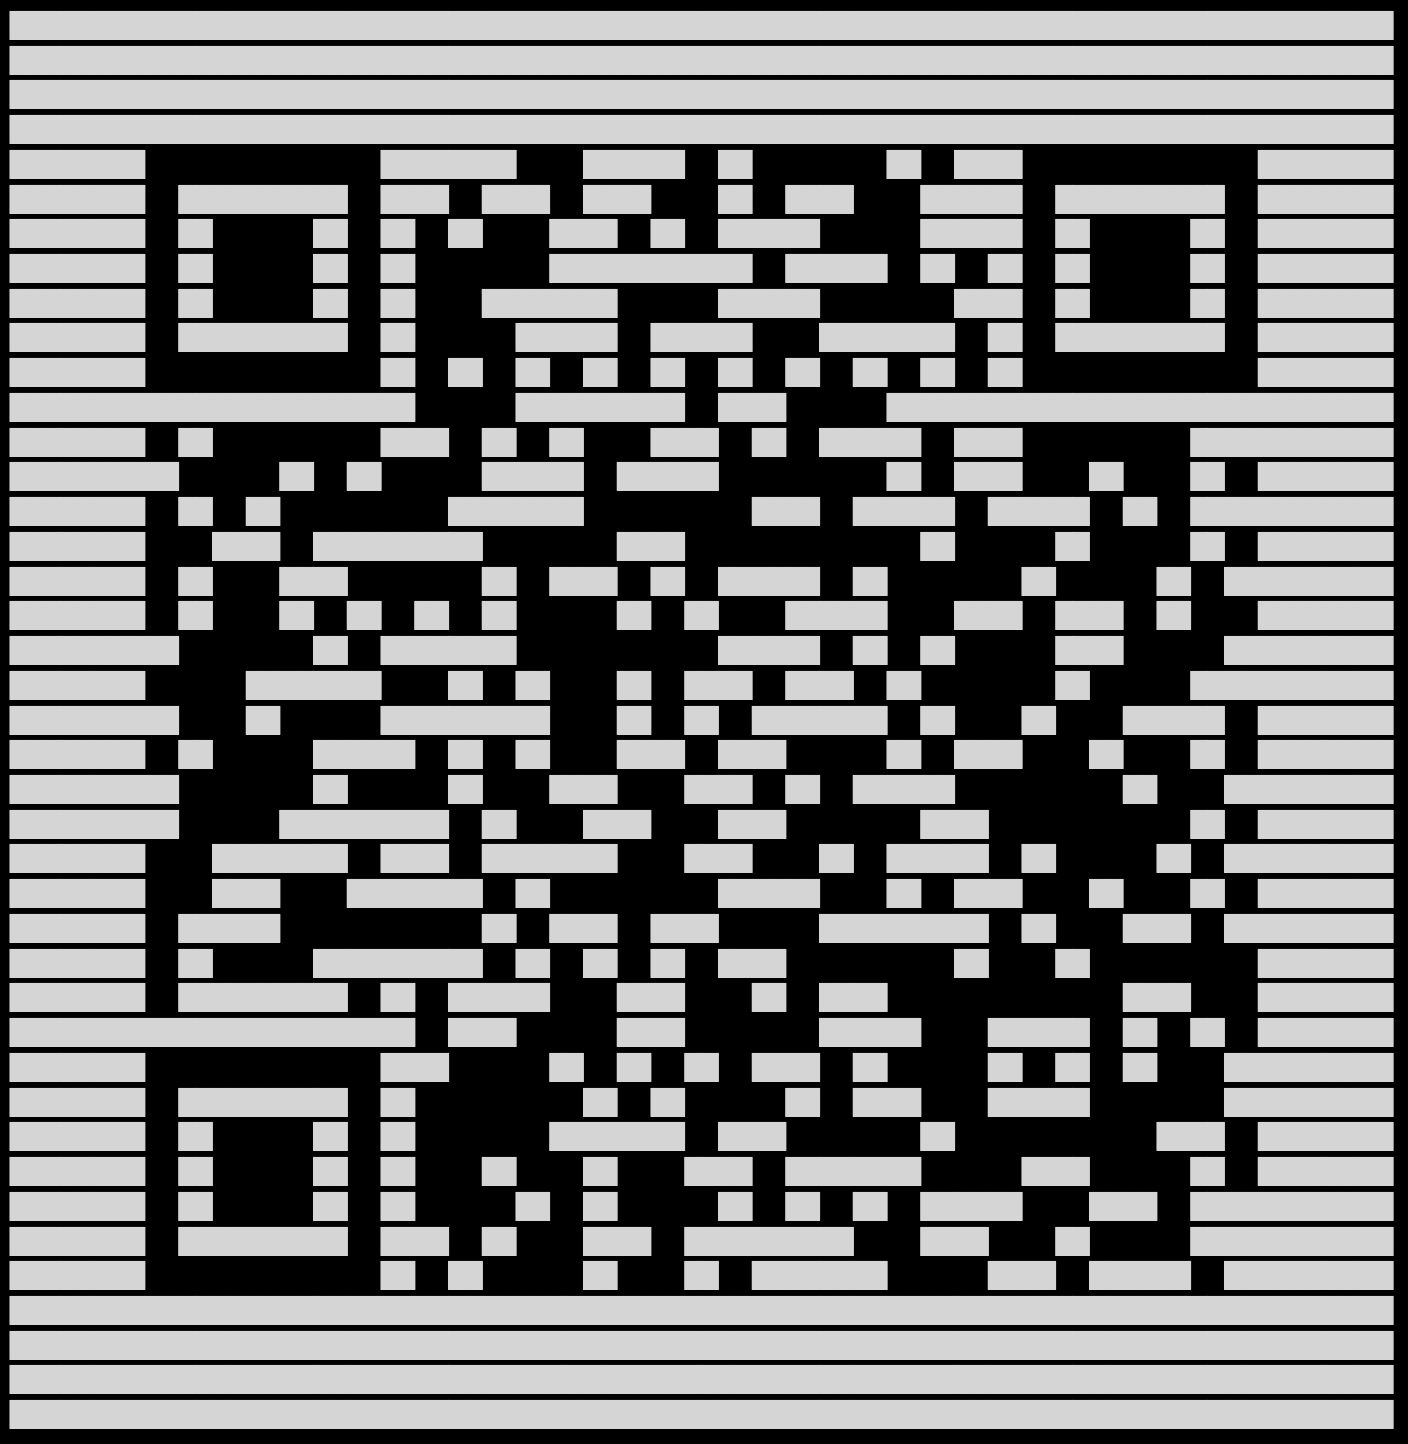

In [151]:
display(Image(filename='demo/qr_code_github.png', width=128, height=128))

### Feedback Delay Network
An FDN is a recursive system consisting of delay lines $m = [m_1, \dots, m_N]$, a set of gains $\mathbf{b}, \mathbf{c}$,   
and a scalar feedback matrix $\mathbf{A}$ through which the delay outputs are coupled to the delay inputs.  


The transfer function of an FDN is $H(z) = \mathbf{c}^\top\big[\mathbf{D_m}(z)^{-1} -\mathbf{A}\big]^{-1}\mathbf{b} + d$   
where the delay matrix $\mathbf{D_m}(z)$ is a diagonal matrix whose diagonal entries are given by $[z^{-m_1}, \dots, z^{-m_N}]$  

##### Modal decomposition
The impulse respose (IR) of the FDN can be represented as the sum of complex one pole models, or resonators, in the time domain:   
$h(n) = \sum_{i=1}^N |\rho_i||\lambda_i|^ne^{\jmath(n\angle\lambda_i+\angle\rho_i)} $  
Similarly, the transfer fuction can be represented in terms of its poles $\rho$ and residues $\lambda$ from its partial fraction decomposition as  
$H(z) = d + \sum_{i=1}^N\frac{\rho_i}{1-\lambda_iz^{-1}}$

Pole $\rho_i$ determines the decay rate and frequency of the $i$-th mode, while residual $\lambda_i$ defines the exitation and initial phase of the $i$-th mode. 

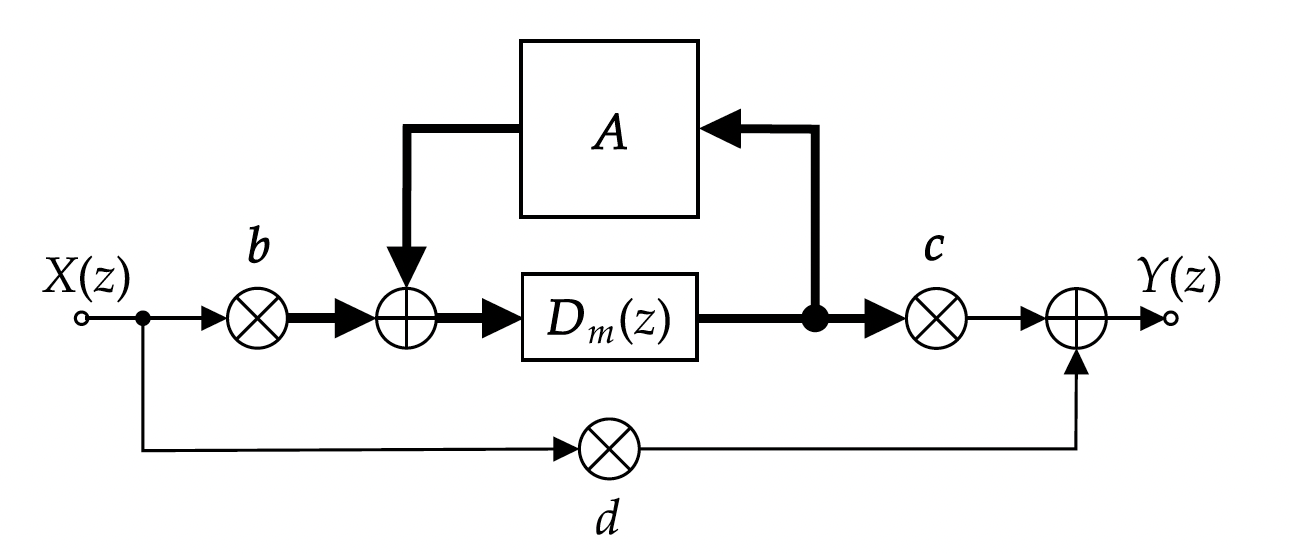

In [152]:
display(Image(filename='demo/fdn_blockdiagram.png', width=512, height=512))

#### Dataset 
This work applies the frequency-sampling method to approximate an FDN as a finite-impulse-response (FIR) filter.  
This is done by evaluating the delay matrix in the transfer function, $\mathbf{D_m}(\bar{z}_M)$, at discrete frequency points in the vector  
$\vec{z}_M = [e^{\jmath \pi \frac{0}{M}}, e^{\jmath \pi \frac{1}{M}}, \dots, e^{\jmath \pi \frac{M-1}{M}}]$  

The dataset consists of vectors of frequency points, equally distributed on the unit circle, with different length $M$.  
In this way, at every training step $H(z)$ is computed on a different set of frequency points. 


Generating dataset: 100%|██████████| 256/256 [00:00<00:00, 108022.32it/s]


Text(0, 0.5, 'Imag')

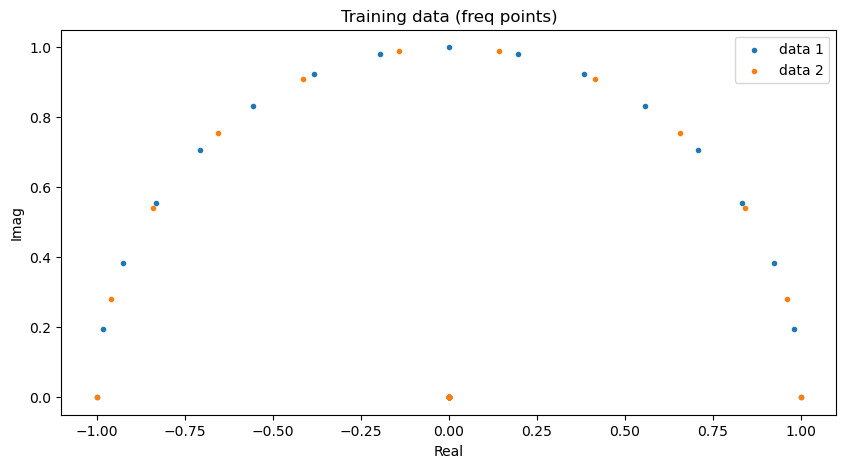

In [153]:
import torch 
from solver import *
import demo.args as args   

# set low value of nfft just for illustrative puproses
# during training we use 
args.max_nfft = 24
args.min_nfft = 12

# load training and validation dataset
train_dataset, valid_dataset = load_dataset(args)

train_ex, _ = next(iter(train_dataset))
plt.scatter(torch.real(train_ex[0,:]), torch.imag(train_ex[0,:]), marker=".",  label='data 1')
plt.scatter(torch.real(train_ex[2,:]), torch.imag(train_ex[2,:]), marker=".",  label='data 2')
plt.legend()
plt.title("Training data (freq points)")
plt.xlabel("Real")
plt.ylabel("Imag")

In [154]:
args.train_dir = 'demo/pretrained'
args.max_nfft = 480000
# input frequency sampling points
x = get_frequency_samples(args.max_nfft)
# load model and state
net = DiffFDN(args.delays, args.gain_per_sample, args.device)
net.load_state_dict(torch.load( 
    os.path.join(args.train_dir, 'model_e0.pt'), 
    map_location=torch.device('cpu')))
H_init, h_init, _ = net(x)
net.load_state_dict(torch.load( 
    os.path.join(args.train_dir, 'model_e' + str(args.max_epochs - 1) +'.pt'), 
    map_location=torch.device('cpu')))
H_end, h_end, _ = net(x)
# load losses
losses = scipy.io.loadmat(os.path.join(args.train_dir,'losses.mat'))



tensor(2.6281e-07, grad_fn=<DistBackward0>)


#### Loss function 
$\mathcal{L} = \mathcal{L}_\textrm{spectral}(\hat{\boldsymbol{H}}(\bar{z}_{M})) +\alpha \mathcal{L}_\textrm{temporal}(\hat{h})$  
$\mathcal{L} = \frac{1}{K} \sum_{i = 1}^N \sum_{k = 1}^K({{|\hat{H}_i(\bar{z}_{M}[k])|}-1})^p + \alpha \frac{||{\hat{h}}||_2}{||{\hat{h}}||_1}$

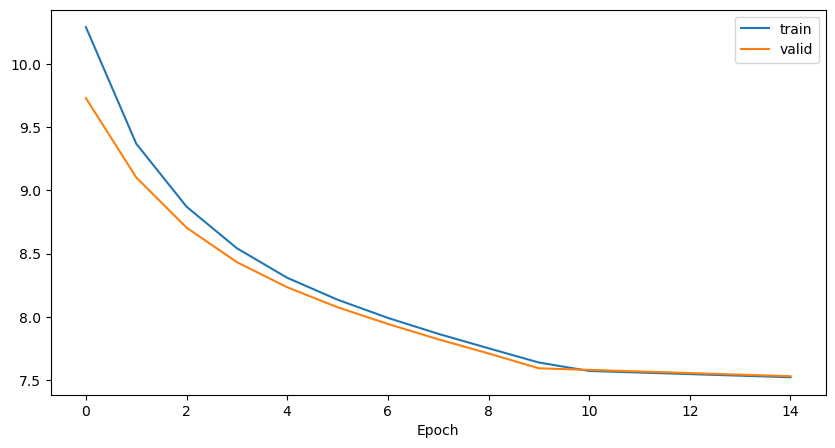

In [155]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(losses['train'][0], label='train')
plt.plot(losses['valid'][0], label='valid')
plt.xlabel('Epoch')
plt.legend()

((-3.5, 2.0),
 Text(0.5, 1.0, 'Magnitude response'),
 Text(0.5, 0, 'Angular Frequecy'))

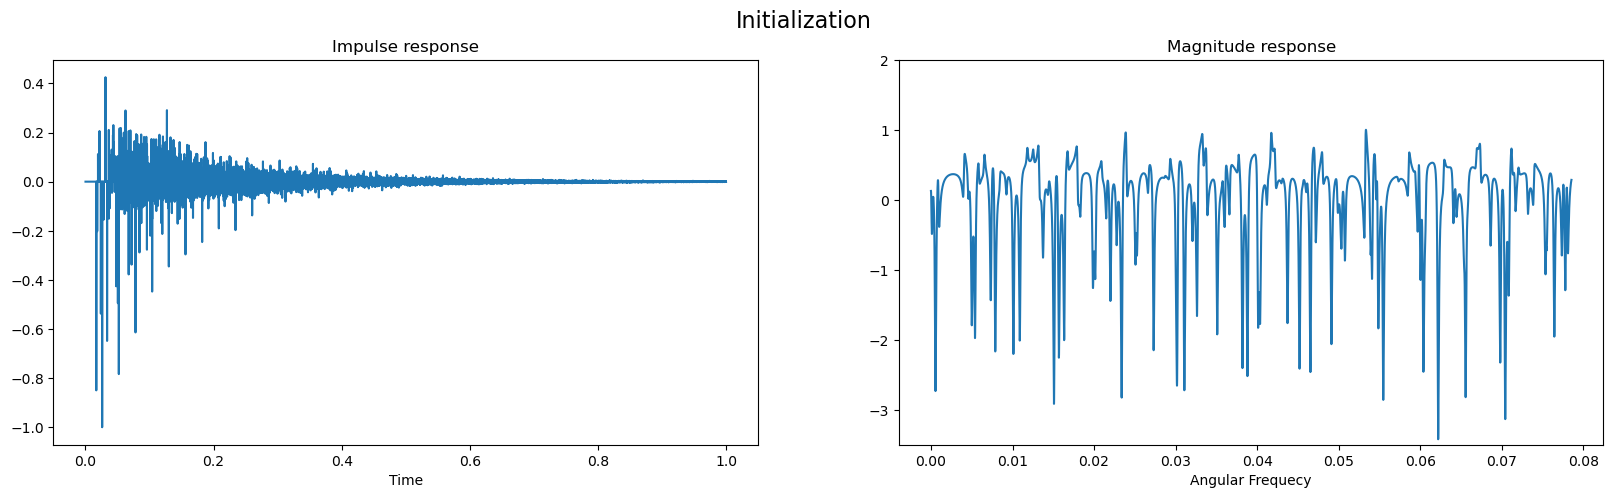

In [173]:
plt.rcParams['figure.figsize'] = [20, 5]

audio_widget = IPython.display.Audio(h_init[:2*args.samplerate].detach().numpy(), rate = args.samplerate)
IPython.display.display(audio_widget)

fig, ax = plt.subplots(1, 2)
fig.suptitle('Initialization', fontsize=16)
t = np.arange(0, 1, 1/args.samplerate)
ax[0].plot(t, h_init[:1*args.samplerate].detach().numpy())
ax[0].set_title('Impulse response'), ax[0].set_xlabel('Time')
ax[1].plot(torch.angle(x[:12000]), torch.sum(H_init, dim=-1)[:12000].detach().numpy())
ax[1].set_ylim(-3.5, 2), ax[1].set_title('Magnitude response'), ax[1].set_xlabel('Angular Frequecy')

(Text(0.5, 0, 'Angular Frequecy'),
 Text(0.5, 1.0, 'Magnitude response'),
 (-3.5, 2.0))

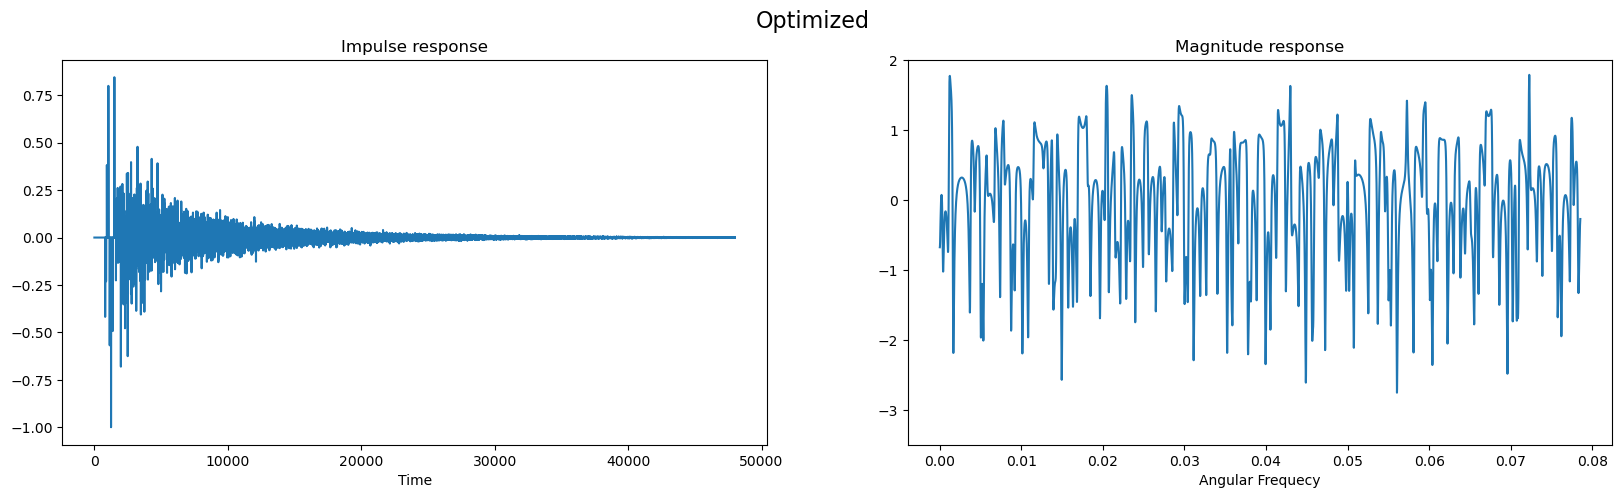

In [174]:
audio_widget = IPython.display.Audio(h_end[:2*args.samplerate].detach().numpy(), rate = args.samplerate)
IPython.display.display(audio_widget)

fig, ax = plt.subplots(1, 2)
fig.suptitle('Optimized', fontsize=16)
ax[0].plot(h_end[:1*args.samplerate].detach().numpy()), ax[0].set_title('Impulse response'), ax[0].set_xlabel('Time')
ax[1].plot(torch.angle(x[:12000]), torch.sum(H_end, dim=-1)[:12000].detach().numpy())
ax[1].set_xlabel('Angular Frequecy'), ax[1].set_title('Magnitude response'), ax[1].set_ylim(-3.5, 2) 


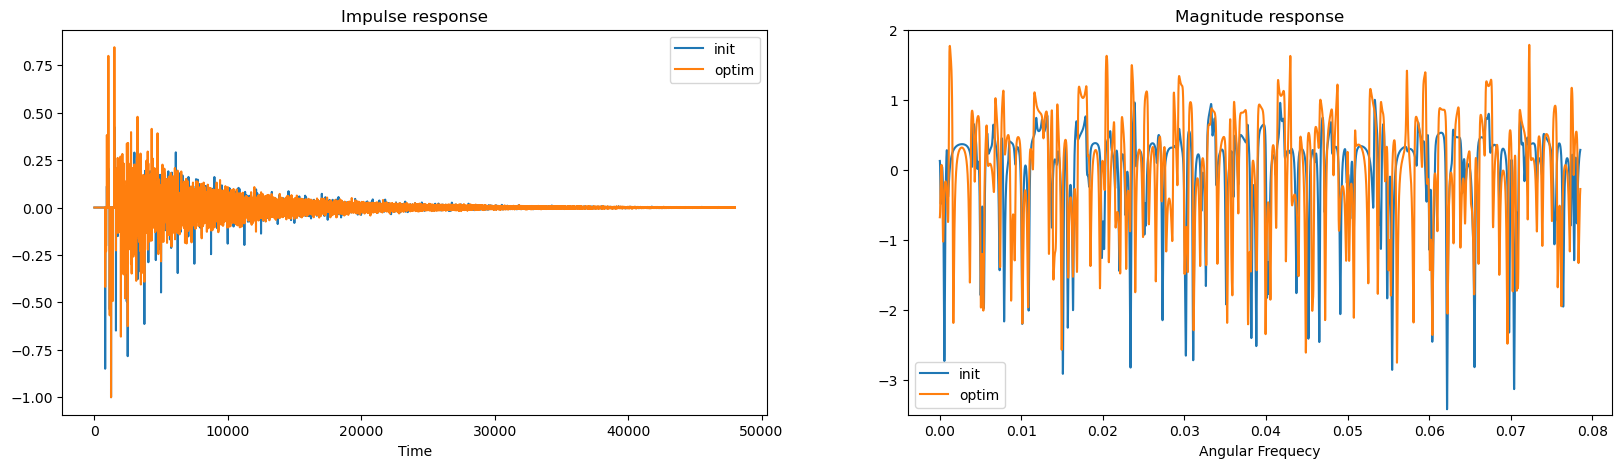

In [175]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(h_init[:1*args.samplerate].detach().numpy(), label='init')
ax[0].plot(h_end[:1*args.samplerate].detach().numpy(), label='optim')
ax[0].set_title('Impulse response'), ax[0].set_xlabel('Time'), ax[0].legend()
ax[1].plot(torch.angle(x[:12000]), torch.sum(H_init, dim=-1)[:12000].detach().numpy(), label='init')
ax[1].plot(torch.angle(x[:12000]), torch.sum(H_end, dim=-1)[:12000].detach().numpy(), label='optim')
ax[1].set_title('Magnitude response'), ax[1].set_xlabel('Angular Frequecy'), ax[1].set_ylim(-3.5, 2)
ax[1].legend()

### Modal excitation

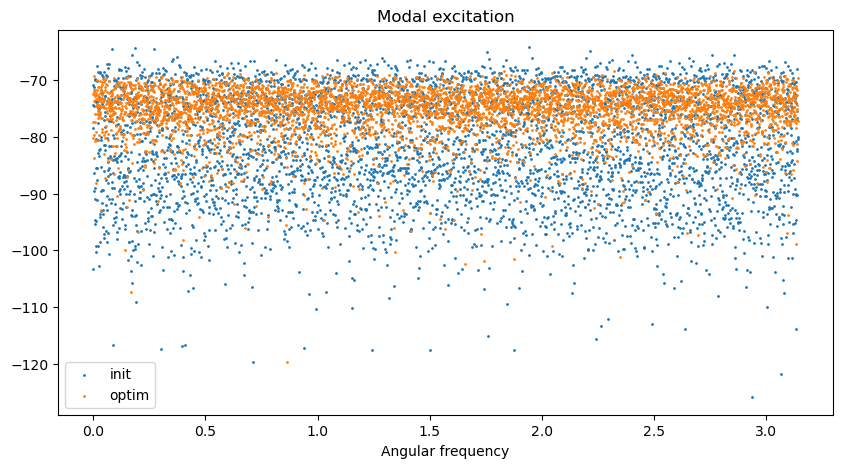

In [170]:
plt.rcParams['figure.figsize'] = [10, 5]

# load modal decomposition results
poles = scipy.io.loadmat(os.path.join(args.train_dir,'poles.mat'))['poles']
residues = scipy.io.loadmat(os.path.join(args.train_dir,'residues.mat'))['residues']
types = ["initDiffFDN", "DiffFDN"]
plt.scatter(np.angle(poles[types[0]][0][0]), 20*np.log10(np.abs(residues[types[0]][0][0])), s=1, label='init')
plt.scatter(np.angle(poles[types[1]][0][0]), 20*np.log10(np.abs(residues[types[1]][0][0])), s=1, label='optim')
plt.xlabel('Angular frequency')
plt.title('Modal excitation')
plt.legend()

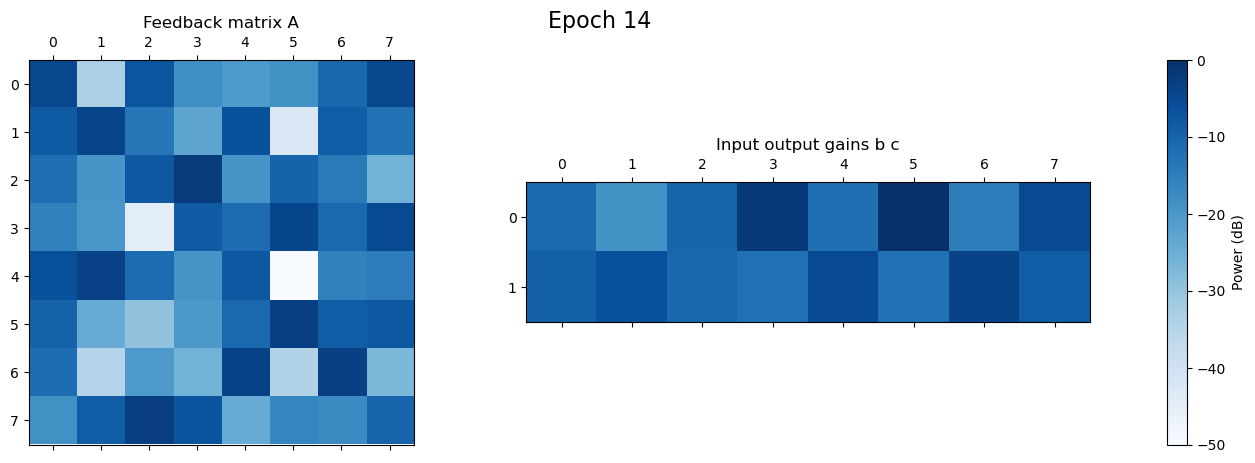

In [159]:
n_epochs = 15
args.max_nfft = 480000

fig, ax = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = [20, 5]

for epoch in range(n_epochs):
    # load model parameters
    net.load_state_dict(torch.load( 
        os.path.join(args.train_dir, 'model_e' + str(epoch) + '.pt'), 
        map_location=torch.device('cpu')))
    # plot feedback matrix 
    im = ax[0].matshow(
        20*np.log10(torch.abs(net.A.weight).detach().numpy()), cmap=plt.cm.Blues, 
        vmin = -50, vmax = 0)
    ax[0].set_title('Feedback matrix A')
    # plot input output gains
    im = ax[1].matshow(
        20*np.log10(torch.vstack(
            (torch.abs(net.B.data).squeeze(dim=0).transpose(1, 0).squeeze(dim=0),
            torch.abs(net.C.data).squeeze(dim=0))).detach().numpy()), 
            cmap=plt.cm.Blues, 
        vmin = -50, vmax = 0)
    ax[1].set_title('Input output gains b c')
    fig.suptitle('Epoch ' + str(epoch) , fontsize=16)
    # Add a colorbar
    
    if epoch == 0:
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', ticks=[0, -10, -20, -30, -40, -50])
        cbar.set_label('Power (dB)')
        cbar.set_ticks([0, -10, -20, -30, -40, -50])
    
    IPython.display.display(fig)
    IPython.display.clear_output(wait=True)
    time.sleep(1)